### Team Members:
1. Nitya Bhamidipaty - CS21BTECH11041
2. Akshay Santoshi - CS21BTECH11012

### Assignment 2 - Example Dependent Cost Sensitive Classification

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
import pygad

%matplotlib inline
np.random.seed(42)
NUM_OFFSET_POINTS = 40 # for plotting

### Dataset Description:

In [2]:
df = pd.read_csv('costsensitiveregression - costsensitiveregression.csv')
df.head()

,NotCount,YesCount,ATPM,PFD,PFG,SFD,SFG,WP,WS,AH,AN,Status,FNC
0,2,21,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
1,23,0,0.0,0.044,0.0,0.0,0.0,0.306179,0.0,0.0,0.0,1,0.0
2,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
3,5,18,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,0.0
4,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0


In [3]:
df.describe()

,NotCount,YesCount,ATPM,PFD,PFG,SFD,SFG,WP,WS,AH,AN,Status,FNC
count,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,1.476360e+05
mean,7.722107,15.220908,0.253245,0.027062,0.050789,0.021648,0.071709,0.271927,0.493587,0.045045,0.013474,0.298586,5.334049e+02
std,7.574278,7.596921,0.366280,0.335509,0.373370,0.298285,1.135755,2.432425,0.763389,0.182274,0.100973,0.457639,8.774011e+03
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2.000000,10.000000,0.001084,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.820820e-01
50%,4.000000,19.000000,0.033354,0.000000,0.000000,0.000000,0.000000,0.000000,0.097875,0.000000,0.000000,0.000000,1.183562e+01
75%,13.000000,21.000000,0.394372,0.000000,0.000000,0.000000,0.000000,0.061840,0.880929,0.000000,0.000000,1.000000,1.069840e+02
max,23.000000,22.000000,1.000000,79.837480,51.944780,61.556900,209.021870,399.606420,5.000000,1.000000,1.000000,1.000000,1.703186e+06


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147636 entries, 0 to 147635
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   NotCount  147636 non-null  int64  
 1   YesCount  147636 non-null  int64  
 2   ATPM      147636 non-null  float64
 3   PFD       147636 non-null  float64
 4   PFG       147636 non-null  float64
 5   SFD       147636 non-null  float64
 6   SFG       147636 non-null  float64
 7   WP        147636 non-null  float64
 8   WS        147636 non-null  float64
 9   AH        147636 non-null  float64
 10  AN        147636 non-null  float64
 11  Status    147636 non-null  int64  
 12  FNC       147636 non-null  float64
dtypes: float64(10), int64(3)
memory usage: 14.6 MB


In [5]:
len(df)

147636

In [6]:
len(df[df['Status'] == 0]), len(df[df['Status'] == 1])

(103554, 44082)

In [7]:
inputs, targets = df.iloc[:, :11], df.iloc[:, -2:-1]

inputs.head(), targets.head()

(   NotCount  YesCount  ATPM    PFD  PFG  SFD  SFG        WP   WS   AH   AN
 0         2        21   0.0  0.000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0
 1        23         0   0.0  0.044  0.0  0.0  0.0  0.306179  0.0  0.0  0.0
 2         1        22   0.0  0.000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0
 3         5        18   0.0  0.000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0
 4         1        22   0.0  0.000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0,
    Status
 0       0
 1       1
 2       0
 3       1
 4       0)

In [8]:
FNC = df['FNC']
FNC = FNC.to_numpy()
TPC = np.ones(len(FNC), dtype=float)*3
FPC = np.ones(len(FNC), dtype=float)*3
TNC = np.zeros(len(FNC), dtype=float)

# Convert numpy arrays to dataframes
FNC_df = pd.DataFrame(FNC, columns=['FNC'])
FPC_df = pd.DataFrame(FPC, columns=['FPC'])
TNC_df = pd.DataFrame(TNC, columns=['TNC'])
TPC_df = pd.DataFrame(TPC, columns=['TPC'])

# Concatenate the dataframes to inputs
inputs = pd.concat([inputs, FNC_df, FPC_df, TNC_df, TPC_df], axis=1)
print(inputs.head())

   NotCount  YesCount  ATPM    PFD  PFG  SFD  SFG        WP   WS   AH   AN  \
0         2        21   0.0  0.000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   
1        23         0   0.0  0.044  0.0  0.0  0.0  0.306179  0.0  0.0  0.0   
2         1        22   0.0  0.000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   
3         5        18   0.0  0.000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   
4         1        22   0.0  0.000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   

   FNC  FPC  TNC  TPC  
0  0.0  3.0  0.0  3.0  
1  0.0  3.0  0.0  3.0  
2  0.0  3.0  0.0  3.0  
3  0.0  3.0  0.0  3.0  
4  0.0  3.0  0.0  3.0  


In [9]:
X = inputs.to_numpy(dtype=float)
y = targets.to_numpy(dtype=float)

X, y

(array([[ 2., 21.,  0., ...,  3.,  0.,  3.],
        [23.,  0.,  0., ...,  3.,  0.,  3.],
        [ 1., 22.,  0., ...,  3.,  0.,  3.],
        ...,
        [ 2., 21.,  1., ...,  3.,  0.,  3.],
        [ 3., 20.,  1., ...,  3.,  0.,  3.],
        [ 6., 17.,  1., ...,  3.,  0.,  3.]]),
 array([[0.],
        [1.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]))

In [10]:
def cal_avg_cost(y, y_pred, FNC, TNC, FPC, TPC):
    """
    Calculate the average cost of the model
    """
    
    y = y.astype(int)
    total_cost = 0
    
    for i in range(len(y)):
        
        if y[i] == y_pred[i]:
            if y[i] == 0: # True Negative
                total_cost += TNC[i]
            else: # True Positive
                total_cost += TPC[i]
                
        elif y[i] == 1: # False Negative
            total_cost += FNC[i]
        else: # False Positive
            total_cost += FPC[i]
    
    return total_cost/len(y)

### Basic Approach: Vanilla Logistic Regression

In [11]:
def sigma(x):
    x = np.clip(x, -500, 500)
    return 1/(1+np.exp(-x))

def loss(y, y_pred):
    m = y.shape[0]
    y_pred = np.clip(y_pred, 1e-10, 1-1e-10)
    return -1/m*np.sum((1-y)*np.log(1-y_pred ) + y*np.log(y_pred ))

def vanilla_logistic_regression(X, y, lr=0.001, epochs=1000):
    m, n = X.shape
    w = np.random.normal(size=(n, 1))
    b = np.random.normal()
    
    for e in range(epochs):
        z = X@w + b
        y_pred = sigma(z)
        dw = (1/m)*X.T@(y_pred - y)
        db = (1/m)* np.sum(y_pred - y)
        
        w -= lr*dw
        b -= lr*db
        
        if e%100 == 0:
            l = loss(y, y_pred)
            c = cal_avg_cost(y, y_pred, FNC_train, TNC_train, FPC_train, TPC_train)
            print(f'Epoch {e}: loss = {l} cost = {c:.3f}')
            
    return w, b   


def predict(X, w, b, offset=0.5):
    z = X@w + b
    return (sigmoid(z) >= offset).astype(int)     



In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

FNC_train = X_train[:, -4]
FPC_train = X_train[:, -3]
TNC_train = X_train[:, -2]
TPC_train = X_train[:, -1]

FNC_test = X_test[:, -4]
FPC_test = X_test[:, -3]
TNC_test = X_test[:, -2]
TPC_test = X_test[:, -1]

X_train = X_train[:, :-4]
X_test = X_test[:, :-4]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
weights, bias = vanilla_logistic_regression(X_train, y_train)

Epoch 0: loss = 0.6741153030979848 cost = 159.332
Epoch 100: loss = 0.6564639362000043 cost = 159.332
Epoch 200: loss = 0.6401202447626039 cost = 159.332
Epoch 300: loss = 0.6249699608206893 cost = 159.332
Epoch 400: loss = 0.6109009143135004 cost = 159.332
Epoch 500: loss = 0.5978152603135554 cost = 159.332
Epoch 600: loss = 0.5856350445935755 cost = 159.332
Epoch 700: loss = 0.5742799433451042 cost = 159.332
Epoch 800: loss = 0.5636807863626483 cost = 159.332
Epoch 900: loss = 0.5537759758882661 cost = 159.332


In [14]:
print('weights:', weights.ravel())
print('bias:', bias.ravel())

weights: [ 0.68961351 -0.33149557  0.49047335  1.47642829 -0.29460439 -0.24049448
  1.53037013  0.7157335  -0.51060307  0.4223025  -0.4358109 ]
bias: [-0.54186686]


In [15]:
y_pred_test = predict(X_test, weights, bias)
y_pred_train = predict(X_train, weights, bias)
accuracy = np.mean(y_pred_test == y_test)
print(f'Test Accuracy: {accuracy:.4f}')
accuracy = np.mean(y_pred_train == y_train)
print(f'Train Accuracy: {accuracy:.4f}')

Test Accuracy: 0.8097
Train Accuracy: 0.8056


In [16]:
offsets = np.linspace(0, 1, NUM_OFFSET_POINTS)
avg_train_costs_vanilla = []
avg_test_costs_vanilla = []


for offset in offsets:
    y_pred_train = predict(X_train, weights, bias, offset)
    avg_train_costs_vanilla.append(cal_avg_cost(y_train, y_pred_train, FNC_train, TNC_train, FPC_train, TPC_train))
    y_pred_test = predict(X_test, weights, bias, offset)
    avg_test_costs_vanilla.append(cal_avg_cost(y_test, y_pred_test, FNC_test, TNC_test, FPC_test, TPC_test))

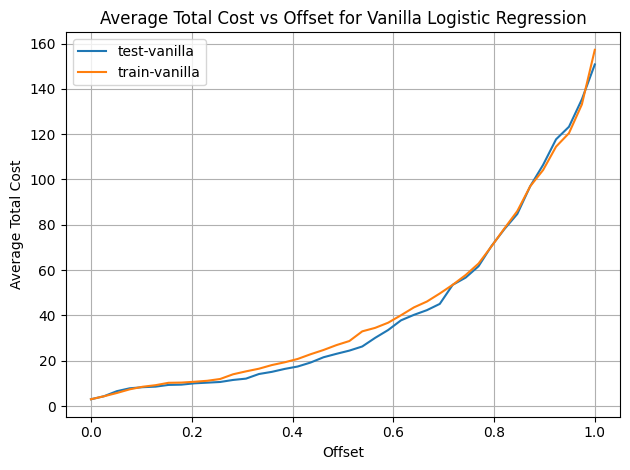

In [17]:
plt.title('Average Total Cost vs Offset for Vanilla Logistic Regression')
plt.plot(offsets, avg_test_costs_vanilla, label='test-vanilla')
plt.plot(offsets, avg_train_costs_vanilla, label='train-vanilla')
plt.xlabel('Offset')
plt.ylabel('Average Total Cost')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

### Approach 2: Bahnsen's Logistic Regression

##### Using PyGAD Library for Genetic Algorithm

In [18]:
!pip install pygad

In [19]:
def bahnsen_loss(weights_bias, X, y, FNC, FPC, TPC, TNC):
    """
    Compute Bahnsen's cost-sensitive logistic regression loss.

    Args:
        weights_bias: Array containing weights and bias (n_features + 1,)
        X: Feature matrix (n_samples, n_features)
        y: Binary labels (n_samples,)
        FNC: False Negative Costs (n_samples,)
        FPC: False Positive Costs (n_samples,)
        TPC: True Positive Costs (n_samples,)
        TNC: True Negative Costs (n_samples,)

    Returns:
        Scalar loss value.
    """
    n_features = X.shape[1]
    weights = weights_bias[:n_features].reshape(-1, 1)
    bias = weights_bias[n_features]
    y = y.reshape(-1, 1)
    FNC = FNC.reshape(-1, 1)
    FPC = FPC.reshape(-1, 1)
    TPC = TPC.reshape(-1, 1)
    TNC = TNC.reshape(-1, 1)

    logits = np.dot(X, weights) + bias
    probabilities = sigmoid(logits)

    loss_matrix = y * (probabilities * TPC + (1 - probabilities) * FNC) + \
                  (1 - y) * (probabilities * FPC + (1 - probabilities) * TNC)
    return np.mean(loss_matrix)

In [20]:
# Fitness function
def fitness_func(ga_instance, solution, solution_idx):
    loss = bahnsen_loss(solution, X_train, y_train, FNC_train, FPC_train, TPC_train, TNC_train)
    return -loss  # PyGAD maximizes fitness, so minimize loss by returning its negative

# Number of genes (weights + bias)
num_genes = X_train.shape[1] + 1 

# Define the GA instance
ga_instance = pygad.GA(num_generations=100,
                       num_parents_mating=5,
                       fitness_func=fitness_func,  # Updated function
                       sol_per_pop=10,
                       num_genes=num_genes,
                       init_range_low=-2,
                       init_range_high=2,
                       mutation_percent_genes=10,
                       mutation_type="random",
                       mutation_by_replacement=True,
                       random_mutation_min_val=-0.1,
                       random_mutation_max_val=0.1,
                       random_seed=42,
                       crossover_type='single_point',
                       parent_selection_type='rws',
                       mutation_probability=0.1,
                       crossover_probability=0.7,
                       gene_type=np.float32
                       )

# Run the GA optimization
ga_instance.run()

# Retrieve the best solution
best_solution, best_solution_fitness, _ = ga_instance.best_solution()

In [21]:
print("Best Weights and Bias:", best_solution)
print("Best Solution Fitness (Negative Loss):", best_solution_fitness)

Best Weights and Bias: [ 0.077021   -0.69926673  0.9184247   0.07879453 -0.00411684  0.08774386
  0.05513093  0.05948358  0.06553588 -0.01446142  0.03309459 -0.03421604]
Best Solution Fitness (Negative Loss): -13.601408813447982


In [22]:
theta_best = best_solution[:-1].reshape(-1, 1)  # Shape: (n_features, 1)
bias_best = best_solution[-1]  # Scalar value

In [24]:
offsets = np.linspace(0, 1, NUM_OFFSET_POINTS)
avg_train_costs_bahnsen = []
avg_test_costs_bahnsen = []

best_train_offset = 0
best_test_offset = 0


for offset in offsets:
    y_pred_train = predict(X_train, theta_best, bias_best, offset)
    cost = cal_avg_cost(y_train, y_pred_train, FNC_train, TNC_train, FPC_train, TPC_train)
    avg_train_costs_bahnsen.append(cost)
    if len(avg_train_costs_bahnsen) > 0 and cost == min(avg_train_costs_bahnsen):
        best_train_offset = offset
    y_pred_test = predict(X_test, theta_best, bias_best, offset)
    cost = cal_avg_cost(y_test, y_pred_test, FNC_test, TNC_test, FPC_test, TPC_test)
    if len(avg_test_costs_bahnsen) > 0 and cost == min(avg_test_costs_bahnsen):
        best_test_offset = offset
    avg_test_costs_bahnsen.append(cost)

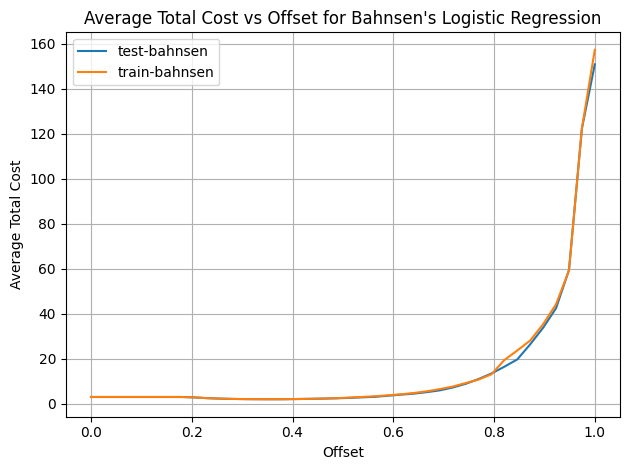

Best offset wrt Test Data: 0.1794871794871795
Best offset wrt Train Data: 0.358974358974359


In [25]:
plt.title('Average Total Cost vs Offset for Bahnsen\'s Logistic Regression')
plt.plot(offsets, avg_test_costs_bahnsen, label='test-bahnsen')
plt.plot(offsets, avg_train_costs_bahnsen, label='train-bahnsen')
plt.xlabel('Offset')
plt.ylabel('Average Total Cost')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()
print(f'Best offset wrt Test Data: {best_test_offset}')
print(f'Best offset wrt Train Data: {best_train_offset}')

### Comparison between the two approaches

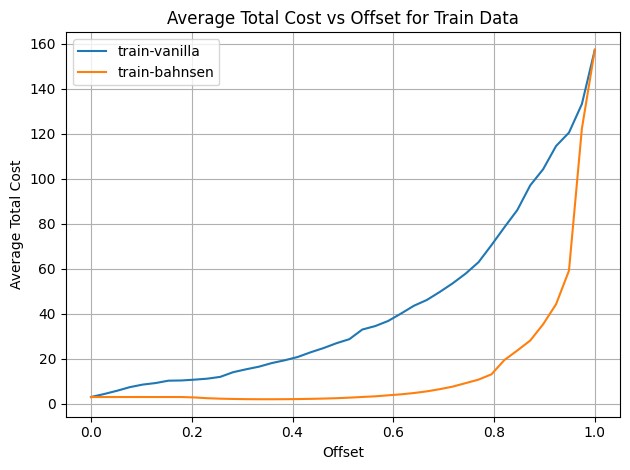

In [26]:
plt.title('Average Total Cost vs Offset for Train Data')
plt.plot(offsets, avg_train_costs_vanilla, label='train-vanilla')
plt.plot(offsets, avg_train_costs_bahnsen, label='train-bahnsen')
plt.xlabel('Offset')
plt.ylabel('Average Total Cost')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

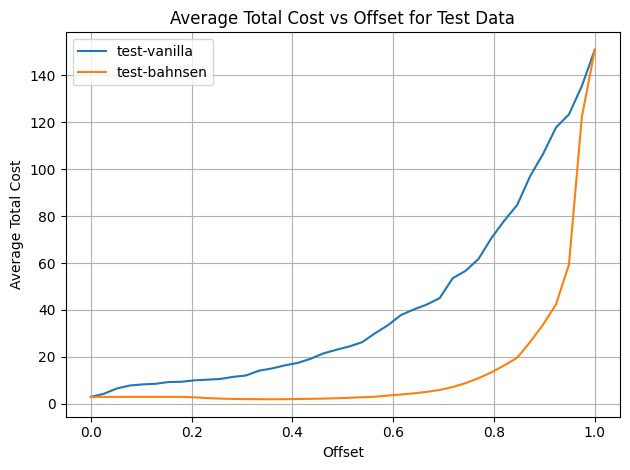

In [27]:
plt.title('Average Total Cost vs Offset for Test Data')
plt.plot(offsets, avg_test_costs_vanilla, label='test-vanilla')
plt.plot(offsets, avg_test_costs_bahnsen, label='test-bahnsen')
plt.xlabel('Offset')
plt.ylabel('Average Total Cost')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

### Results
- Cost Sensitive Logisitic regression performs better than Vanilla Logistic Regression for all offsets.
- The best offset for test data is 0.1 and train is 0.35 which shows that 0.5 threshold is sub-optimal.